**Install PyTorch3D**

In [1]:
! pip install "git+https://github.com/facebookresearch/pytorch3d.git"

  Cloning https://github.com/facebookresearch/pytorch3d.git to /tmp/pip-req-build-al8jc1s8
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-al8jc1s8
  Resolved https://github.com/facebookresearch/pytorch3d.git to commit 055ab3a2e3e611dff66fa82f632e62a315f3b5e7
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 423, in run
    _, build_failures = build(
  File "/usr/l

**Import the libraries we'll need for the training**

In [1]:
# Just running with my mini data project imports for now, clean up later
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap
import random

**Preprocessing**

In [2]:
# Preprocessing
from pytorch3d.io import load_obj
from pytorch3d.structures import Meshes
import trimesh
import numpy as np
! wget https://dl.fbaipublicfiles.com/pytorch3d/data/dolphin/dolphin.obj
trg_obj = 'dolphin.obj'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# We read the target 3D model using load_obj
verts, faces, aux = load_obj(trg_obj)

# verts is a FloatTensor of shape (V, 3) where V is the number of vertices in the mesh
# faces is an object which contains the following LongTensors: verts_idx, normals_idx and textures_idx
faces_idx = faces.verts_idx
verts = verts

# We scale normalize and center the target mesh to fit in a sphere of radius 1 centered at (0,0,0).
# (scale, center) will be used to bring the predicted mesh to its original center and scale
# Note that normalizing the target mesh, speeds up the optimization but is not necessary!
center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale

# Remesh the normalized vertices and faces
remeshed = trimesh.Trimesh(vertices=verts, faces=faces.verts_idx)
# Voxelize the mesh
voxel = trimesh.voxel.creation.voxelize(remeshed, 0.0625, method="subdivide")
# Matrix representation of voxel
voxel_matrix = voxel.matrix
# Define matrix of empty desired voxel size
reshaped_voxel = np.zeros((32, 32, 32))
# Place to put the voxel in that
x_padding = int((32 - voxel_matrix.shape[0]) / 2)
y_padding = int((32 - voxel_matrix.shape[1]) / 2)
z_padding = int((32 - voxel_matrix.shape[2]) / 2)
# Put the voxel occupancy in its designated spot in the empty 3D Matrix
reshaped_voxel[x_padding: x_padding + voxel_matrix.shape[0], y_padding: y_padding + voxel_matrix.shape[1], z_padding: z_padding + voxel_matrix.shape[2]] = voxel_matrix
# Turn matrix representation into VoxelGrid
new_voxel = trimesh.voxel.base.VoxelGrid(reshaped_voxel)
# Channel dim is 1, binary occupied or not
voxel_training_data = torch.Tensor(reshaped_voxel).unsqueeze(0)
# print(f"voxel: {new_voxel.shape}")
mc = new_voxel.marching_cubes

# Save the remeshed surface as an STL file
mc.export("test.stl")

--2024-12-18 14:13:15--  https://dl.fbaipublicfiles.com/pytorch3d/data/dolphin/dolphin.obj
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.173.166.51, 18.173.166.48, 18.173.166.74, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.173.166.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156763 (153K) [text/plain]
Saving to: ‘dolphin.obj.17’

dolphin.obj.17      100%[===================>] 153.09K  --.-KB/s    in 0.09s   

2024-12-18 14:13:15 (1.59 MB/s) - ‘dolphin.obj.17’ saved [156763/156763]



/home/jess/anaconda3/envs/jaxrl/lib/python3.10/site-packages/pytorch3d/io/obj_io.py:546: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xd4\x0c\x00\x00:\xcd\x13\xbf:\xcd\x13\xbf:\xcd\x13\xbf\x00\x00\x10A\x00\x00\x80A\x00\x00\x9cA\x00\x00\x10A\x00\x00xA\x00\x00\xa0A\x00\x00\x08A\x00\x00\x80A\x00\x00\xa0A\x00\x00\xf3\x045\xbf\xf3\x045\xbf\x00\x00\x00\x80\x00\x00\x10A\x00\x00xA\x00\x00\xa8A\x00\x00\x08A\x00\x00\x80A\x00\x00\xa8A\x00\x00\x08A\x00\x00\x80A\x00\x00\xa0A\x00\x00\xf3\x045\xbf\xf3\x045\xbf\x00\x00\x00\x00\x00\x00\x10A\x00\x00xA\x00\x00\xa8A\x00\x00\x08A\x00\x00\x80A\x00\x00\xa0A\x00\x00\x10A\x00\x00xA\x00\x00\xa0A\x00\x00:\xcd\x13\xbf:\xcd\x13\xbf:\xcd\x13?\x00\x00\x10A\x00\x00\x80A\x00\x00\xacA\x00\x00\x08A\x00\x00\x80A\x00\x00\xa8A\x00\x00\x10A\x00\x00xA\x00\x00\xa8A\x00\x00:\xcd\x13\xbf:\xcd

**Custom Dataloader**

In [3]:
import io
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

data = [voxel_training_data, voxel_training_data, voxel_training_data, voxel_training_data, voxel_training_data, voxel_training_data, voxel_training_data, voxel_training_data, voxel_training_data, voxel_training_data, voxel_training_data, voxel_training_data, voxel_training_data, voxel_training_data, voxel_training_data, voxel_training_data]

class VoxelizedHoldsDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, data):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        print(self.data[idx].shape)
        return self.data[idx]

In [4]:
dset = VoxelizedHoldsDataset(data) 
dataloader = DataLoader(dset, batch_size=16,
                        shuffle=True, num_workers=4)

In [5]:
# Define the GAN architectures. These should largely be mirrored, just different
# inputs and outputs

# Generator model
class Generator(nn.Module):
    """ Docstring emoji later """
    def __init__(self, in_channels=200, int_channels1=512, int_channels2=256, int_channels3=128, int_channels4=64):
        super(Generator,self).__init__()
        # Add math here for the intermediate layer sizes if necessary

        # Define the model layers, likely transposed convolutional layers
        self.transpose_conv1 = nn.ConvTranspose3d(in_channels, int_channels1, kernel_size=4, stride=2, padding=1)
        self.transpose_conv2 = nn.ConvTranspose3d(int_channels1, int_channels2, kernel_size=4, stride=2, padding=1)
        self.transpose_conv3 = nn.ConvTranspose3d(int_channels2, int_channels3, kernel_size=4, stride=2, padding=1)
        self.transpose_conv4 = nn.ConvTranspose3d(int_channels3, int_channels4, kernel_size=4, stride=2, padding=1)
        self.transpose_conv5 = nn.ConvTranspose3d(int_channels4, 1, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        # Add batch normalization????
        # Implement the forward pass of the model here using Relu for the
        # generator
        out = F.relu(self.transpose_conv1(x))
        out = F.relu(self.transpose_conv2(out))
        out = F.relu(self.transpose_conv3(out))
        out = F.relu(self.transpose_conv4(out))
        out = F.relu(self.transpose_conv5(out))

        # If all went well this should be a 1x32x32x32 tensor
        return out

# Discriminator model
class Discriminator(nn.Module):
    """ This more or less mirrors the generator """
    def __init__(self, int_channels1=64, int_channels2=128, int_channels3=256, int_channels4=512, int_channels5=200):
        super(Discriminator,self).__init__()
        # Add math here for the intermediate layer sizes

        # Define the model layers, likely transposed convolutional layers
        self.conv1 = nn.Conv3d(1, int_channels1, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv3d(int_channels1, int_channels2, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv3d(int_channels2, int_channels3, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv3d(int_channels3, int_channels4, kernel_size=4, stride=2, padding=1)
        self.conv5 = nn.Conv3d(int_channels4, 1, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        # Add batch normalization???
        # Implement the forward pass of the model here
        out = F.leaky_relu(self.conv1(x))
        out = F.leaky_relu(self.conv2(out))
        out = F.leaky_relu(self.conv3(out))
        out = F.leaky_relu(self.conv4(out))
        out = F.sigmoid(self.conv5(out))

        # If all went well this should be a binary classification output
        return out

**Imports for Training**

In [17]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

# Root directory for dataset
# dataroot = "data/celeba"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 16

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 200

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100


# Number of training epochs
num_epochs = 1000

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

Random Seed:  999


In [18]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [19]:
def smoothness_loss(fake):
    return torch.sum(torch.abs(fake[:, :, :-1] - fake[:, :, 1:])) + \
           torch.sum(torch.abs(fake[:, :-1, :] - fake[:, 1:, :])) + \
           torch.sum(torch.abs(fake[:-1, :, :] - fake[1:, :, :]))

lambda_smooth = 1e-3

In [20]:
'''
Training loop
'''

# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

# Create the Discriminator
netD = Discriminator(ngpu).to(device)


# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(2, 200, 1, 1, device=device)
# fixed_noise = torch.randn(1, 200, 1, 1, device=device) # Cuda out of memory 112

# Establish convention for real and fake labels during training
real_label = 0.9
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    print(f"epoch: {epoch}")
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        print(f"output: {output.shape}")
        print(f"label: {label.shape}")
        print("Output min:", output.min().item(), "Output max:", output.max().item())

        # # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        # ## Train with all-fake batch
        # # Generate batch of latent vectors
        noise = torch.randn(b_size, 1, 1, 1, device=device)
        # # Generate fake image batch with G
        fake = netG(noise)
        print(fake.shape)
        label.fill_(fake_label)
        # # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        print(output.shape)
        # # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # # Update D
        optimizerD.step()

        # ############################
        # # (2) Update G network: maximize log(D(G(z)))
        # ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # # Calculate G's loss based on this output
        # errG = criterion(output, label)
        errG = criterion(output, label) + lambda_smooth * smoothness_loss(fake)

        # # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # # Update G
        optimizerG.step()

        # # Output training stats
        if i % 1 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        iters += 1

Generator(
  (transpose_conv1): ConvTranspose3d(1, 512, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
  (transpose_conv2): ConvTranspose3d(512, 256, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
  (transpose_conv3): ConvTranspose3d(256, 128, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
  (transpose_conv4): ConvTranspose3d(128, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
  (transpose_conv5): ConvTranspose3d(64, 1, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
)
Generator(
  (transpose_conv1): ConvTranspose3d(1, 512, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
  (transpose_conv2): ConvTranspose3d(512, 256, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
  (transpose_conv3): ConvTranspose3d(256, 128, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
  (transpose_conv4): ConvTranspose3d(128, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
  (transpose_conv5): C

In [28]:
fake = netG(noise).squeeze()
threshold = 0.2  # Adjust based on your use case
binary_fake = (fake > threshold).cpu().numpy().astype(bool)
# print("Voxel grid unique values:", np.unique(binary_fake))
print(fake.shape)
from skimage.transform import resize

# Resize the voxel grid to a smaller resolution
# resampled_voxel = resize(fake.detach().cpu().numpy(), (16, 16, 16), order=1, mode='reflect', anti_aliasing=True)

# Threshold after resampling
# binary_voxel = (resampled_voxel > 0.3).astype(bool)

new_voxel = trimesh.voxel.base.VoxelGrid(binary_fake)

print(f"voxel: {new_voxel.shape}")
mc = new_voxel.marching_cubes

# Save the remeshed surface as an STL file
mc.export("test3.stl")


torch.Size([32, 32, 32])
voxel: (32, 32, 32)


b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xd2\r\x00\x00:\xcd\x13\xbf:\xcd\x13\xbf:\xcd\x13\xbf\x00\x00\x10A\x00\x00\x80A\x00\x00\xa4A\x00\x00\x10A\x00\x00xA\x00\x00\xa8A\x00\x00\x08A\x00\x00\x80A\x00\x00\xa8A\x00\x00:\xcd\x13\xbf:\xcd\x13\xbf:\xcd\x13?\x00\x00\x10A\x00\x00\x80A\x00\x00\xacA\x00\x00\x08A\x00\x00\x80A\x00\x00\xa8A\x00\x00\x10A\x00\x00xA\x00\x00\xa8A\x00\x00\xf3\x045\xbf\x00\x00\x00\x00\xf3\x045\xbf\x00\x00\x10A\x00\x00\x80A\x00\x00\xa4A\x00\x00\x08A\x00\x00\x80A\x00\x00\xa8A\x00\x00\x08A\x00\x00\x88A\x00\x00\xa8A\x00\x00\xf3\x045\xbf\x00\x00\x00\x00\xf3\x045\xbf\x00\x00\x10A\x00\x00\x80A\x00\x00\xa4A\x00\x00\x08A\x00\x00\x88A\x00\x00\xa8A\x00\x00\x10A\x00\x00\x88A\x00\x00\xa4A\x00\x00\xf3\x045\x

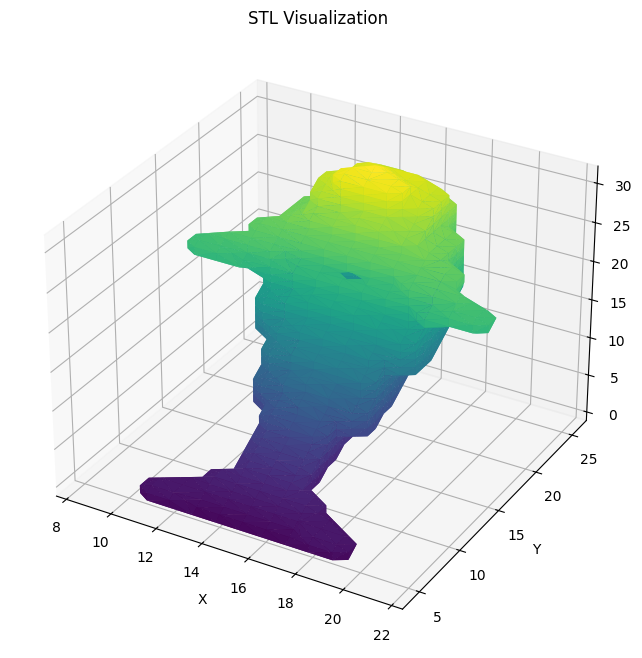

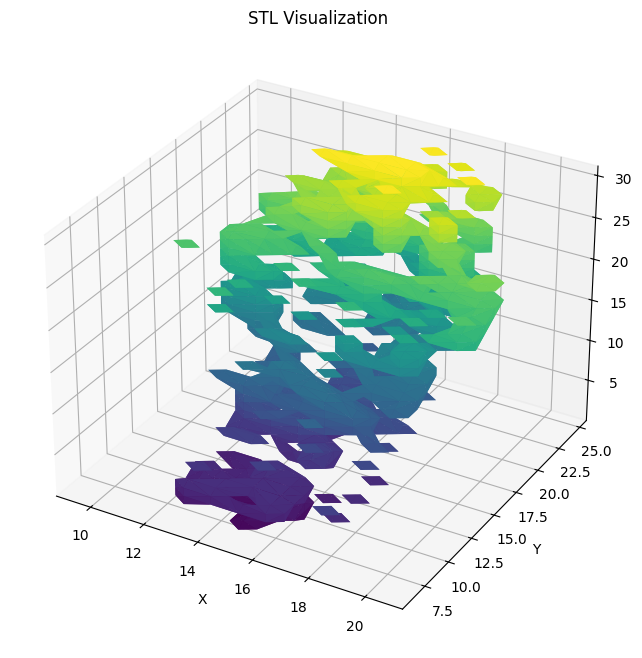

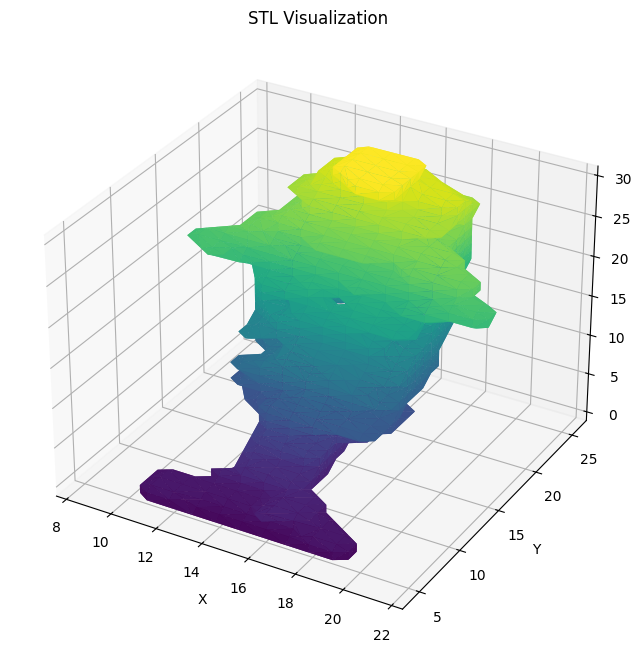

In [29]:
import trimesh
import matplotlib.pyplot as plt

# Load the STL file
mesh = trimesh.load("test.stl")

# Create a Matplotlib 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the mesh
ax.plot_trisurf(
    mesh.vertices[:, 0], mesh.vertices[:, 1], mesh.vertices[:, 2],
    triangles=mesh.faces, cmap="viridis", edgecolor="none"
)

# Set labels
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.title("STL Visualization")

# Load the STL file
mesh = trimesh.load("test2.stl")

# Create a Matplotlib 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the mesh
ax.plot_trisurf(
    mesh.vertices[:, 0], mesh.vertices[:, 1], mesh.vertices[:, 2],
    triangles=mesh.faces, cmap="viridis", edgecolor="none"
)

# Set labels
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.title("STL Visualization")

# Save the figure as an image
plt.savefig("stl_visualization.png")
plt.show()

# Load the STL file
mesh = trimesh.load("test3.stl")

# Create a Matplotlib 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the mesh
ax.plot_trisurf(
    mesh.vertices[:, 0], mesh.vertices[:, 1], mesh.vertices[:, 2],
    triangles=mesh.faces, cmap="viridis", edgecolor="none"
)

# Set labels
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.title("STL Visualization")

# Save the figure as an image
plt.savefig("stl_visualization.png")
plt.show()